In [507]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier, ExtraTreesClassifier,\
                             BaggingClassifier, VotingClassifier)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from time import time

### Entre cada uno de los integrantes del grupo fuimos obteniendo distintos features que nos parecieron interesantes y que consideramos que podrian servir para las predicciones.

#### Leemos los distintos CSVs que contienen los features


In [508]:
features_gaby = pd.read_csv('../features/features_gaby.csv')
features_gonza = pd.read_csv('../features/features_gonza.csv').drop(columns='Unnamed: 0')
features_ari = pd.read_csv('../features/features_ariel.csv')
features_mati = pd.read_csv('../features/features_frecuencia.csv')
labels_training_set = pd.read_csv('~/Escritorio/dataset/labels_training_set.csv')
test_set = pd.read_csv('~/Escritorio/dataset/trocafone_kaggle_test.csv')
features_gonza2 = pd.read_csv('../features/features_gonza2.csv')

## Mergeamos todos los features en un solo dataframe de la forma <persona, feature1, feature2,...,...>

In [509]:
#model_df = pd.merge(features_gaby, features_gonza, how='inner', on='person')
model_df = pd.merge(features_gaby, features_ari, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza2, how='inner', on='person')
model_df = pd.merge(model_df, features_mati, how='inner', on='person')
model_df.head()

,person,marca_favorita_apple,marca_favorita_asus,marca_favorita_lenovo,marca_favorita_lg,marca_favorita_motorola,marca_favorita_no tiene,marca_favorita_quantum,marca_favorita_samsung,marca_favorita_sony,...,visited site,completa_flujo,favorite_device_Computer,favorite_device_Smartphone,favorite_device_Tablet,favorite_device_Unknown,Frecuencia_Casi_nunca,Frecuencia_Esporadico,Frecuencia_Frecuente,Frecuencia_Nunca
0,0008ed71,1,0,0,0,0,0,0,0,0,...,2.0,False,1,0,0,0,0,0,0,1
1,00091926,1,0,0,0,0,0,0,0,0,...,34.0,False,1,0,0,0,0,0,0,1
2,00091a7a,1,0,0,0,0,0,0,0,0,...,1.0,False,0,1,0,0,0,0,0,1
3,000ba417,0,0,0,0,0,0,0,1,0,...,6.0,False,1,0,0,0,1,0,0,0
4,000c79fe,1,0,0,0,0,0,0,0,0,...,1.0,False,0,1,0,0,0,0,0,1


In [510]:
model_df.fillna(value=0, inplace=True)

## Al dataframe de las personas con sus features le agregamos los labels para saber si cada persona o no realizo una compra.

## Tambien tenemos un dataframe de test, el cual contiene todas las personas que queremos predecir y sus features ( queremos predecir sus labels)

In [511]:
training_set = pd.merge(model_df, labels_training_set, how='inner', on='person')
test_set = pd.merge(model_df, test_set, how='inner', on='person')
#training_set.drop(columns= 'Unnamed: 0', inplace=True)

## Como se puede observar en nuestro set de entrenamiento predomina el label 0, la mayoria de las personas no realizo una conversion, esto debemos balancearlo.

In [512]:
training_set['label'].value_counts()

0    18434
1      980
Name: label, dtype: int64

## Elimino 17500 filas que contienen el label 0 para balancear el set de entrenamiento.

# <font color='red'> Preguntar de cual es la mejor manera de hacer esto</font>

In [513]:
#training_set.sort_values(by='month_moda', ascending=True, inplace=True)
#r_training_set = training_set.drop(training_set[training_set.label.eq(0)].head(17500).index)

In [514]:
r_training_set = training_set.drop(training_set[training_set.label.eq(0)].sample(17454).index)
r_training_set['label'].value_counts()

1    980
0    980
Name: label, dtype: int64

In [515]:
r_training_set.month_moda.value_counts()

5    1556
4     185
3     122
2      51
1      46
Name: month_moda, dtype: int64

In [516]:
training_set['month_moda'].value_counts()

5    17242
4     1044
3      643
2      274
1      211
Name: month_moda, dtype: int64

In [517]:
r_training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1960 entries, 10 to 19397
Data columns (total 69 columns):
person                                   1960 non-null object
marca_favorita_apple                     1960 non-null int64
marca_favorita_asus                      1960 non-null int64
marca_favorita_lenovo                    1960 non-null int64
marca_favorita_lg                        1960 non-null int64
marca_favorita_motorola                  1960 non-null int64
marca_favorita_no tiene                  1960 non-null int64
marca_favorita_quantum                   1960 non-null int64
marca_favorita_samsung                   1960 non-null int64
marca_favorita_sony                      1960 non-null int64
nivel_de_actividad_Muy Bajo              1960 non-null int64
nivel_de_actividad_Bajo                  1960 non-null int64
nivel_de_actividad_Medio                 1960 non-null int64
nivel_de_actividad_Alto                  1960 non-null int64
nivel_de_actividad_Muy Alto         

## En el siguiente array incluimos los features que mas aportan para las predicciones

In [518]:
features = ['cant_total_eventos', #f1
            #'marca_favorita_apple',#f2
            'mean_events_per_day',#f3
           # 'has_converted_before',#f4
            'most_viewed_sku',#f5
            #'most_viewed_color_Preto',#f6
            #'most_viewed_color_Branco',#f7
            #'most_viewed_color_Dourado', #f8
            #'region_brasil_Sao Paulo',#f9
            #'region_brasil_Unknown',#f10
            #'region_brasil_Minas Gerais',#f11
            #'marca_favorita_samsung',#f12
            'cant_ev_noche',#f13
            'cant_ev_manana',#f14
            'cant_ev_tarde',#f15
            'cant_ev_madrugada',#f16
            'cant_buenos',#f17
            'cant_muy_buenos',#f18
            'cant_excelentes',#f19
            #'nivel_de_actividad_Muy Bajo',#f20
            #'nivel_de_actividad_Muy Alto',#f21
            #'nivel_de_actividad_Bajo',#f22
            #'nivel_de_actividad_Medio',#f23
            #'nivel_de_actividad_Alto',#f24
            #'favorite_device_Smartphone',#f25
            'favorite_device_Computer',#f26
            'cantidad_checkouts',#f27
            'cantidad_conversions',#f28
            #'tasa_cc',
            #'cantidad_lead',
            #'cantidad_searchs',
            'month_moda',
            "Frecuencia_Casi_nunca",
            "Frecuencia_Esporadico",
            "Frecuencia_Frecuente",
            "Frecuencia_Nunca"
           ]

## Creo dos arrays el llamado X es generado a partir de mi dataframe de entrenamiento y los features que quiero tener en cuenta
## Y el segundo Y es generado a partir de sus labels

In [519]:
x = np.array(r_training_set[features])
y = np.array(r_training_set['label'])

## Usamos train_test_split para dividir el dataframe de entrenamiento en uno de test y otro de entrenamiento

In [520]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.10, random_state=0)

## El primer algoritmo que utilizamos es KNN

### En el siguiente loop iremos probando KNN con distintos Ks y nos quedaremos con la que obtuvimos mayor accuracy.

In [521]:
best_accuracy = 0
worst_accuracy = 1
best_k = 1
worst_k = 0
best_prediction = []
#acumulated_acuracy = 0
#loop_count = 0;

for i in range(1,203,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = (knn.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test,pred.round(), normalize=False)
    if (accuracy > best_accuracy) :
        best_k = i
        best_accuracy = accuracy
        best_prediction = pred
    if (accuracy < worst_accuracy) : 
        worst_accuracy = accuracy
        worst_k = i
    #loop_count += 1
    #acumulated_acuracy += accuracy
    #X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.10)
        

In [522]:
print ('Best accuracy: ' + str(best_accuracy / float(best_prediction.size)) + ' with k='  + str(best_k))
print ('Worst accuracy: ' + str(worst_accuracy / float(best_prediction.size)) + ' with k= ' + str(worst_k))
#print "Median accuracy " + str(acumulated_acuracy / (float(loop_count) * float(best_prediction.size)))

Best accuracy: 0.6428571428571429 with k=5
Worst accuracy: 0.00510204081632653 with k= 0


## Finalmente corremos KNN con el mejor K obtenido en el entrenamiento y el set que queremos predecir

In [523]:
z = np.array(test_set[features])
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x,y)
pred = knn.predict_proba(z)[:,1]

## Le agregamos las predicciones a los IDs de las personas y lo guardamos en un archivo.


In [524]:
persons = test_set['person']
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/knn.csv', index=False)

## Revisamos la cantidad de conversiones y no conversiones predichas

### Se tienen que repartir en un 50/50

In [525]:
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print ('Cantidad de no conversiones: ' + str(no_conversiones))

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print ('Cantidad de conversiones: ' + str(conversiones))

Cantidad de no conversiones: 11241
Cantidad de conversiones: 8174


## XGBoost

### En los siguientes arrays, ponemos los posibles hiperparametros que concideramos que mejor funcionarian para las predicciones.

### Con grid search probamos todas las combinaciones posibles y nos quedamos con la que mayor accuracy nos dio.

In [526]:
#n_estimators = [100, 200, 1500, 2000]
#max_depth = [2, 4, 6, 8]
#learning_rate = [0.0001, 0.001, 0.01]
#subsample = [0.3, 0.5, 0.7]
#gamma = [0.6, 0.7]
#colsample_bytree = [0.5, 0.7]
min_child_leaf = []
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]

#param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,
#                 learning_rate=learning_rate, subsample=subsample,
#                 gamma=gamma)


In [527]:
#xgboost = xgb.XGBClassifier()
#kfold = StratifiedKFold(n_splits = 2, shuffle=True, random_state=7)
#grid_search = GridSearch(xgboost, param_grid, scoring="neg_log_loss", n_jobs = 1, cv=kfold, verbose=1)
#result = grid_search.fit(x,y)

In [528]:
#pred = (xgboost.predict_proba(z)[:,1])

In [529]:
#pred

In [530]:
#print("Best: %f using %s" % (result.best_score_, result.best_params_))

In [531]:
#means = result.cv_results_['mean_test_score']
#stds = result.cv_results_['std_test_score']
#params = result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#	print("%f (%f) with: %r" % (mean, stdev, param))

### Corremos XGBoost para el set de entrenamiento y medimos su precision

In [532]:
xgboost = xgb.XGBClassifier(learning_rate = 0.001,\
                            n_estimators= 2000,\
                            max_depth= 10,\
                            min_child_weight= 2,\
                            gamma=0.7,\
                            subsample=0.7,\
                            colsample_bytree=0.7,\
                            objective= 'binary:logistic',\
                            scale_pos_weight=1
                           )

xgboost.fit(X_train, y_train)
pred = (xgboost.predict_proba(X_test)[:,1])
accuracy = accuracy_score(y_test, pred.round(), normalize=False)

print("Accuracy: ", accuracy / float(pred.size))

Accuracy:  0.8163265306122449


In [533]:
x_test_df = pd.DataFrame(data=X_test, columns=features)
x_test_df['index'] = x_test_df.index
x_label_pred = pd.DataFrame({'label': y_test, 'pred': pred})
x_label_pred['index'] = x_label_pred.index

In [534]:
merged = pd.merge(x_test_df, x_label_pred, how='inner', on='index')
bad_pred = merged.loc[(merged['label'] == 0) & (merged['pred'] >= 0.5)]

In [535]:
bad_pred

,cant_total_eventos,mean_events_per_day,most_viewed_sku,cant_ev_noche,cant_ev_manana,cant_ev_tarde,cant_ev_madrugada,cant_buenos,cant_muy_buenos,cant_excelentes,...,cantidad_checkouts,cantidad_conversions,month_moda,Frecuencia_Casi_nunca,Frecuencia_Esporadico,Frecuencia_Frecuente,Frecuencia_Nunca,index,label,pred
2,144.0,2.149254,6874.0,41.0,30.0,27.0,46.0,30.0,23.0,7.0,...,3.0,1.0,2.0,0.0,1.0,0.0,0.0,2,0,0.797049
6,15.0,15.000000,6023.0,5.0,0.0,10.0,0.0,4.0,0.0,1.0,...,0.0,0.0,5.0,0.0,0.0,0.0,1.0,6,0,0.630259
7,7.0,0.125000,3180.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,7,0,0.764442
8,9.0,9.000000,6343.0,9.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,1.0,8,0,0.590103
13,19.0,3.166667,6889.0,0.0,12.0,2.0,5.0,4.0,2.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,1.0,13,0,0.647146
19,26.0,26.000000,2692.0,26.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,1.0,19,0,0.745725
20,94.0,9.400000,10462.0,24.0,1.0,58.0,11.0,20.0,3.0,6.0,...,1.0,1.0,5.0,0.0,0.0,1.0,0.0,20,0,0.567265
23,162.0,2.945455,8483.0,0.0,0.0,162.0,0.0,40.0,49.0,43.0,...,0.0,0.0,4.0,0.0,0.0,0.0,1.0,23,0,0.778723
58,41.0,41.000000,12758.0,0.0,0.0,38.0,3.0,6.0,2.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,1.0,58,0,0.599829
59,73.0,12.166667,10086.0,0.0,0.0,73.0,0.0,12.0,14.0,38.0,...,0.0,0.0,5.0,0.0,0.0,0.0,1.0,59,0,0.763277


## Analizamos cuales son los features que mayor peso tienen para xgboost.

In [536]:
print(xgboost.feature_importances_)

[0.11559692 0.11864573 0.15121375 0.08675324 0.02701261 0.09243309
 0.05942064 0.0842822  0.0732336  0.06845151 0.02539488 0.03607015
 0.01973281 0.02842591 0.00058665 0.00216883 0.00499542 0.00558207]


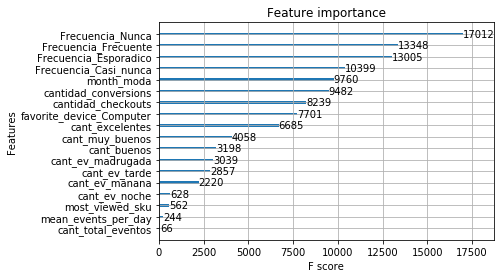

In [537]:
plot = plot_importance(xgboost)
plot.set_yticklabels(features, fontdict=None, minor=False)
pyplot.show()

In [538]:
xgboost = xgb.XGBClassifier(learning_rate = 0.001,\
                            n_estimators= 2000,\
                            max_depth= 6,\
                            min_child_weight= 2,\
                            gamma=0.7,\
                            subsample=0.7,\
                            colsample_bytree=0.7,\
                            objective= 'binary:logistic',\
                            scale_pos_weight=1
                           )
xgboost.fit(x,y)
pred = (xgboost.predict_proba(z)[:,1])

In [539]:
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/xgboost.csv', index=False)

In [540]:
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print ('Cantidad de no conversiones: ' + str(no_conversiones))

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print ('Cantidad de conversiones: ' + str(conversiones))

Cantidad de no conversiones: 13068
Cantidad de conversiones: 6347


In [541]:
submit['label'].mean()

0.3771174

# Random Forest

In [542]:
# Creamos el Random Forest
random_forest = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=6, min_samples_split=3,\
                                   min_samples_leaf=10, bootstrap=True, oob_score=True, warm_start=True)

# Lo entrenamos con nuestro set de entrenamiento
random_forest.fit(X_train,y_train)

# Predecimos valores de nuestro set de datos
pred = random_forest.predict(X_test)

# Evaluamos la precisión
precision = accuracy_score(y_test, pred)

precision

0.8316326530612245

In [543]:
random_forest = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=6, min_samples_split=3,\
                                   min_samples_leaf=10, bootstrap=False, oob_score=False, warm_start=False)

# Lo entrenamos con la totalidad del set de datos
random_forest.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = random_forest.predict(z)

In [544]:
submit = pd.DataFrame({'label': pred_final, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/forest.csv', index=False)

In [545]:
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print ('Cantidad de no conversiones: ' + str(no_conversiones))

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print ('Cantidad de conversiones: ' + str(conversiones))

Cantidad de no conversiones: 13099
Cantidad de conversiones: 6316


# Extra Trees

In [546]:
t0 = time()

# Parámetros óptimos
params_optimos_et = {'n_estimators':100, 'max_features':'sqrt', 'max_depth':5, 'min_samples_split':2,\
                     'min_samples_leaf':2, 'bootstrap':True, 'oob_score':True, 'warm_start':True}

# Creamos el extra_trees
extra_trees = ExtraTreesClassifier(**params_optimos_et)

# Lo entrenamos con nuestro set de entrenamiento
extra_trees.fit(X_train,y_train)

# Predecimos valores de nuestro set de datos
pred = extra_trees.predict(X_test)

# Evaluamos la precisión
precision = accuracy_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.7959183673469388
Tiempo de ejecución: 0.28375 seconds.


In [547]:
t0 = time()

# Creamos el extra trees
extra_trees = ExtraTreesClassifier(**params_optimos_et)

# Lo entrenamos con la totalidad del set de datos
extra_trees.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = extra_trees.predict(z)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Tiempo de ejecución: 0.45238 seconds.


In [548]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print(round(acc_log,2,), "%")

69.33 %


In [554]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=200)
scores = cross_val_score(rf, X_train, y_train, cv=20, scoring = "f1")

In [555]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.77419355 0.72727273 0.77419355 0.68131868 0.7173913  0.73684211
 0.7311828  0.80434783 0.73913043 0.8        0.72       0.8172043
 0.76190476 0.74468085 0.69565217 0.77272727 0.82222222 0.77777778
 0.79591837 0.72941176]
Mean: 0.7561686232141038
Standard Deviation: 0.038975841207909666


In [556]:
importances = pd.DataFrame({'feature':features,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [557]:
importances

,importance
feature,
cantidad_checkouts,0.432
month_moda,0.128
cant_total_eventos,0.086
cant_buenos,0.046
cant_ev_tarde,0.046
mean_events_per_day,0.042
cantidad_conversions,0.037
Frecuencia_Nunca,0.036
cant_ev_noche,0.032


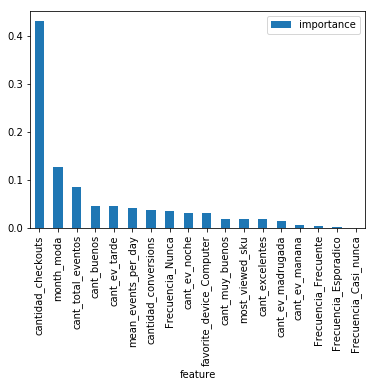

In [553]:
importances.plot.bar()

NameError: name 'X_train' is not defined

In [2]:
from sklearn.ensemble import VotingClassifier

In [ ]:
vc = VotingClassifier()